# Art Generation with Neural Style Transfer

<a name='1'></a>
## Packages

Run the following code cell to import the necessary packages and dependencies we will need to perform Neural Style Transfer.

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
from public_tests import *
%matplotlib inline

In [3]:
# load parameters from the VGG model. This may take a few seconds. 
tf.random.set_seed(272) 
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='pretrained-model/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

The content image C will be the picture of the Louvre Museum in Paris. Run the code below to see a picture of the Louvre.

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.


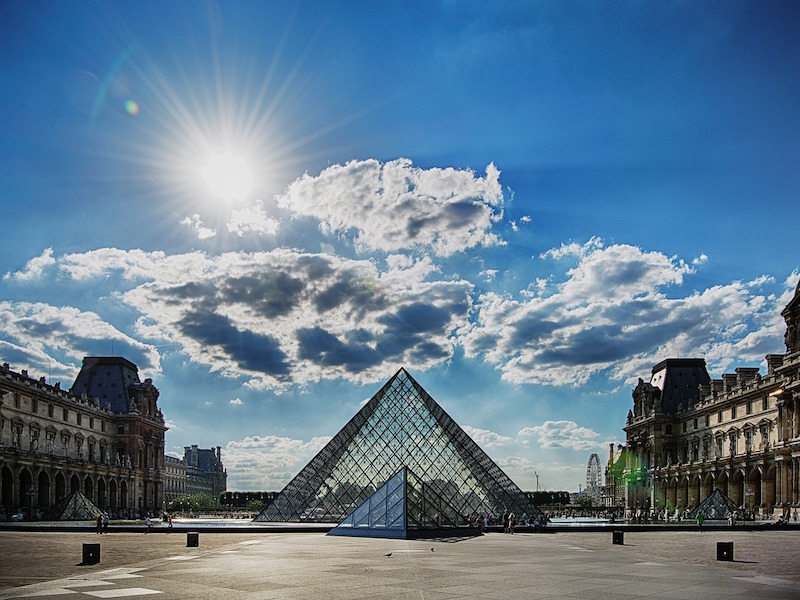

In [4]:
content_image = Image.open("images/louvre.jpg")
print("The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.")
content_image

<a name='ex-1'></a>
### Compute_content_cost

We compute the "content cost" using TensorFlow. 

In [5]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that we compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    

    # Retrieve dimensions from a_G 
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape 'a_C' and 'a_G' 
    a_C_unrolled = tf.reshape(a_C, (1, -1, n_C))
    a_G_unrolled = tf.reshape(a_G, (1, -1, n_C))
    
    # compute the cost with tensorflow 
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C,a_G))/(4*n_H*n_W*n_C))
      
    return J_content

In [6]:
compute_content_cost_test(compute_content_cost)

J_content = tf.Tensor(7.0568776, shape=(), dtype=float32)
All tests passed


<a name='4-2'></a>
### Computing the Style Cost

For this project, we will use the following style image: 

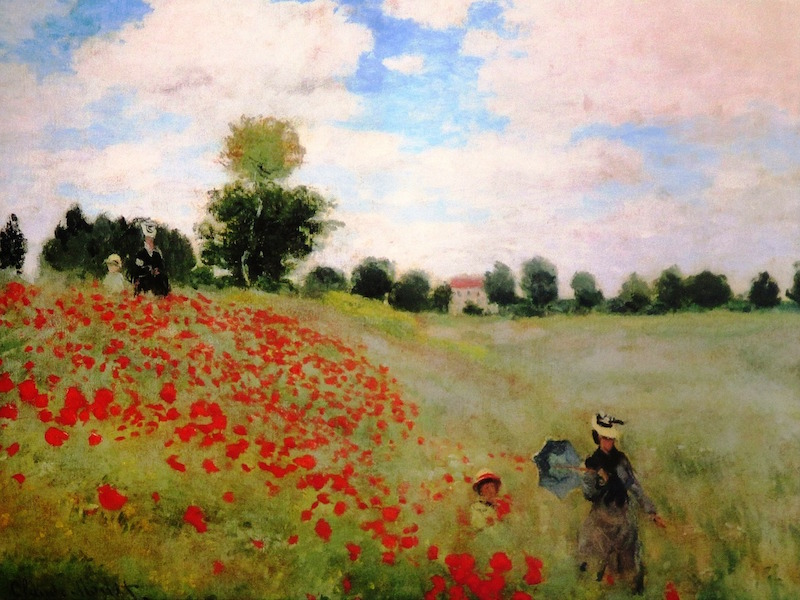

In [7]:
example = Image.open("images/monet_800600.jpg")
example

<a name='ex-2'></a>
### Gram_matrix
Using TensorFlow, we implement a function that computes the Gram matrix of a matrix A. 

In [8]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  

    GA = tf.linalg.matmul(A, tf.transpose(A))
 
    return GA

In [9]:
gram_matrix_test(gram_matrix)

GA = 
tf.Tensor(
[[ 63.193256  -26.729713   -7.732155 ]
 [-26.729713   12.775055   -2.5164719]
 [ -7.732155   -2.5164719  23.746586 ]], shape=(3, 3), dtype=float32)
All tests passed


<a name='4-2-2'></a>
#### Style Cost

<a name='ex-3'></a>
### Compute_layer_style_cost
We should compute the style cost for a single layer. 

In [10]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
   
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, [-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [-1, n_C]))

    # Computing gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss 
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4*(n_C**2)*((n_H*n_W)**2))
    
    return J_style_layer

In [11]:
compute_layer_style_cost_test(compute_layer_style_cost)

J_style_layer = tf.Tensor(14.01649, shape=(), dtype=float32)
All tests passed


<a name='4-2-3'></a>
#### Weights

List of the layer names:

In [12]:
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Now we choose layers to represent the style of the image and assign style costs:

In [14]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

<a name='ex-4'></a>
### Compute_style_cost

In [15]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

<a name='4-3'></a>
### Defining the Total Cost to Optimize

We implement the total cost function which includes both the content cost and the style cost. 

In [16]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
   
    J = alpha * J_content + beta * J_style
    
    return J

In [17]:
total_cost_test(total_cost)

J = tf.Tensor(32.9832, shape=(), dtype=float32)
All tests passed


<a name='5-1'></a>
### Load the Content Image
Run the following code cell to load, reshape, and normalize the "content" image C (the Louvre museum picture):

(1, 400, 400, 3)


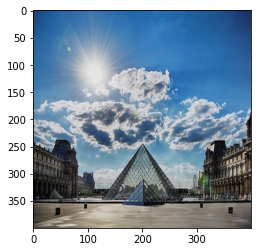

In [18]:
content_image = np.array(Image.open("images/louvre_small.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

<a name='5-2'></a>
### Load the Style Image
Now load, reshape and normalize the "style" image (Claude Monet's painting):

(1, 400, 400, 3)


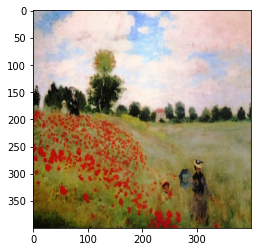

In [19]:
style_image =  np.array(Image.open("images/monet.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

<a name='5-3'></a>
### Randomly Initialize the Image to be Generated
Now, we get to initialize the "generated" image as a noisy image created from the content_image.

(1, 400, 400, 3)


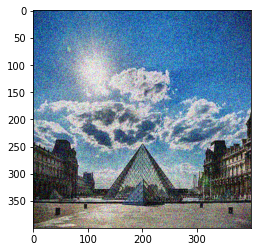

In [20]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

<a name='5-4'></a>
## Load Pre-trained VGG19 Model
Next, we define a function which loads the VGG19 model and returns a list of the outputs for the middle layers.

In [21]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

Now, we should define the content layer and build the model.

In [22]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

We will save the outputs for the content and style layers in separate variables.

In [23]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

<a name='5-5'></a>
### Compute Total Cost

<a name='5-5-1'></a>
#### Compute the Content image Encoding 

In [24]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

<a name='5-5-2'></a>
#### Compute the Style image Encoding

The code below sets a_S to be the tensor giving the hidden layer activation for `STYLE_LAYERS` using our style image.

In [25]:
# Assign the input of the model to be the "style" image 
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Below are the utils that we will need to display the images generated by the style transfer model.

In [26]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<a name='ex-6'></a>
### Train_step 

We implement the train_step() function for transfer learning

In [29]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function we must use the precomputed encoded images a_S and a_C
        
            
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)
              
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

In [30]:
generated_image = tf.Variable(generated_image)

train_step_test(train_step, generated_image)

tf.Tensor(25700.242, shape=(), dtype=float32)
tf.Tensor(17777.762, shape=(), dtype=float32)
All tests passed


Looks like it's working! Now we'll get to put it all together into one function to better see our results!

<a name='5-6'></a>
### Train the Model

Run the following cell to generate an artistic image. Neural Style Transfer is generally trained using GPUs.

Epoch 0 


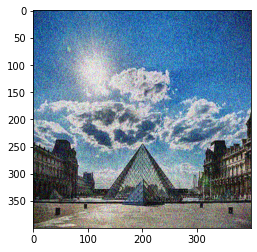

Epoch 250 


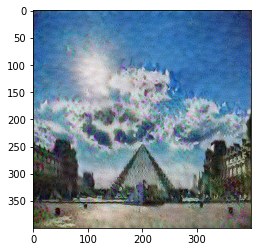

Epoch 500 


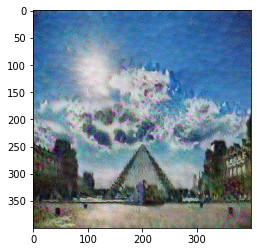

Epoch 750 


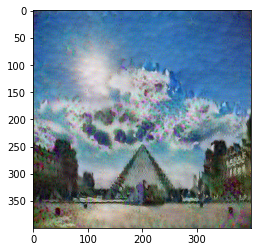

Epoch 1000 


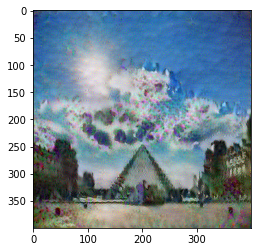

Epoch 1250 


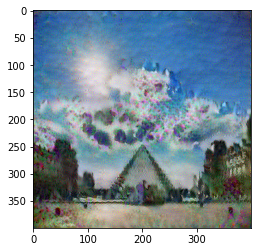

Epoch 1500 


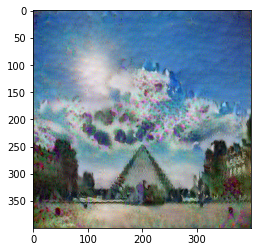

Epoch 1750 


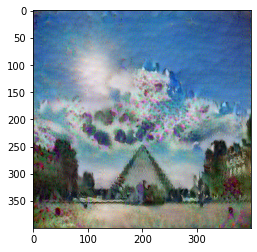

Epoch 2000 


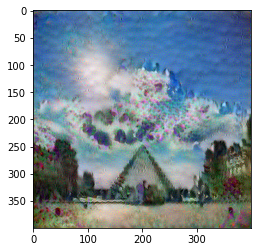

Epoch 2250 


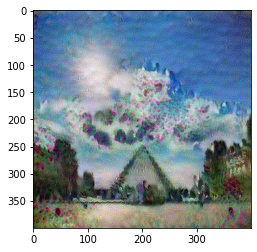

Epoch 2500 


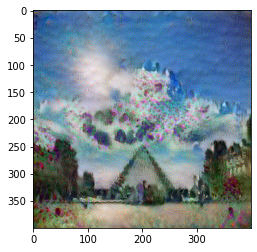

In [31]:
# Show the generated image at some epochs
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"output/image_{i}.jpg")
        plt.show() 

Now, run the following code cell to see the results!

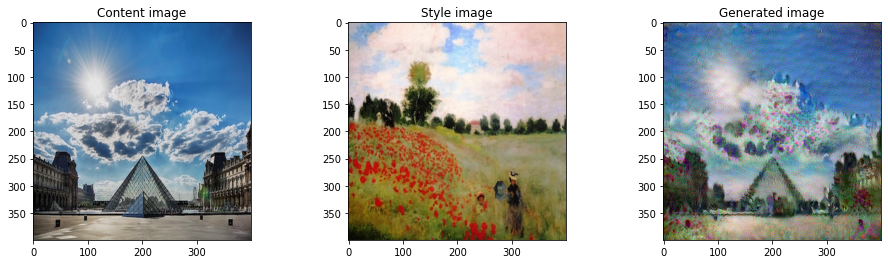

In [32]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(content_image[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()

 The `Generated image` on the right is the image we generated with the model. 

The hyperparameters (`learning_rate=0.01` and `epochs = 2501`) were set to these values so that we didn't have to wait too long to see an initial result. To get the best looking results, we may want to try running the optimization algorithm longer (and perhaps with a smaller learning rate). Running for around `epochs = 20000` with a `learning_rate=0.001`, we will see something like the image presented below on the right.

<center><img src="images/louvre_generated.png" style="width:800px;height:300px;"></center>

## Here are few other examples:

<center><img src="images/perspolis_vangogh.png" style="width:750px;height:300px;"></center><br>

<center><img src="images/pasargad_kashi.png" style="width:750px;height:300px;"></center><br>

<center><img src="images/circle_abstract.png" style="width:750px;height:300px;"></center>